### ITEM -BASED
    - collaborative fitering
    - 평점기반(item)으로 --> 평점을 매기지 않은 영화를 추천

(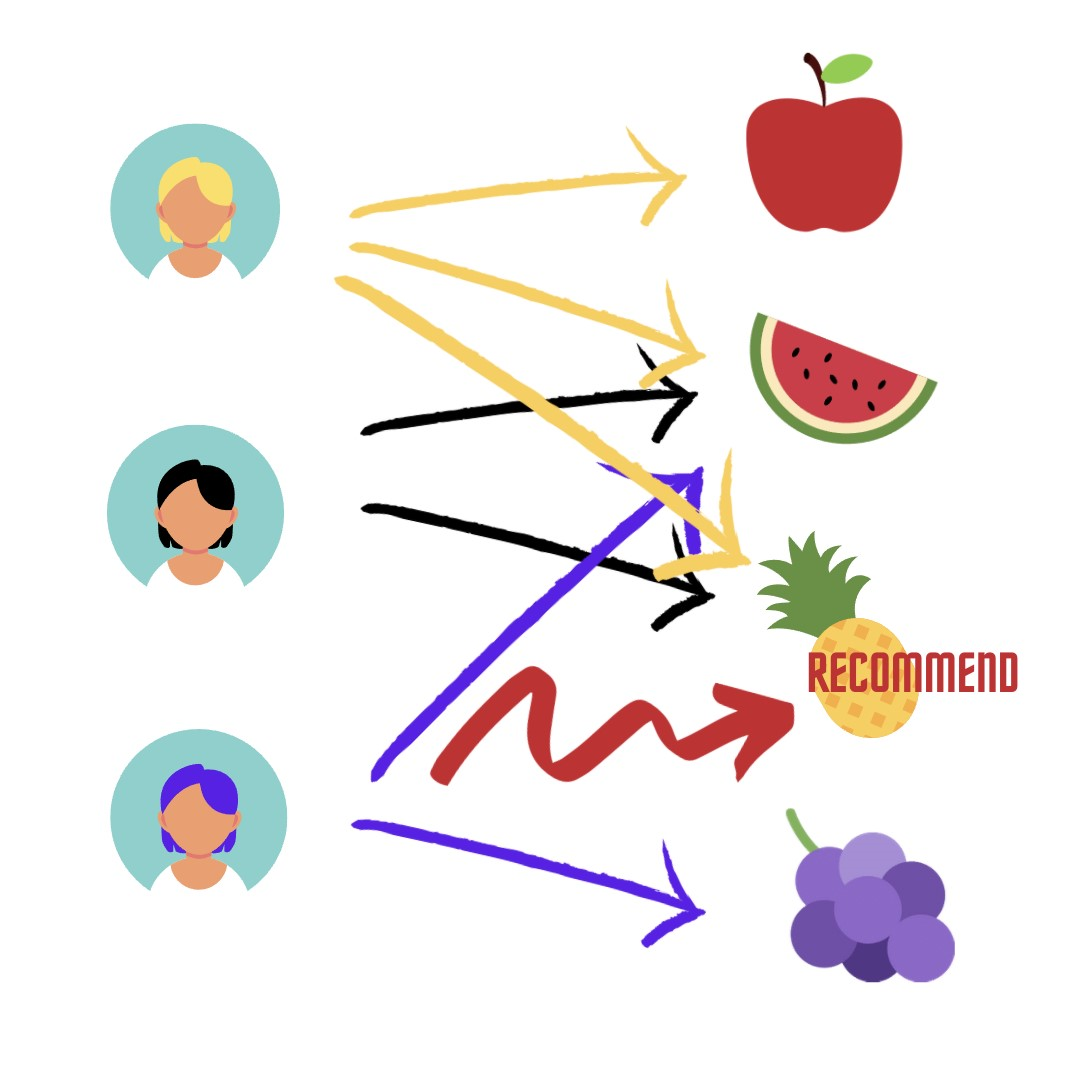)

#### 1. import library and data

In [2]:
import pandas as pd
import numpy as  np
import seaborn as sns
import scipy.stats
from datetime import datetime
import pprint 

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
ratings =pd.read_csv('../datasets/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [68]:
len(ratings['userId'].unique())

610

In [69]:
len(ratings['movieId'].unique())

9724

In [70]:
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [71]:
movies =pd.read_csv('../datasets/movies_small.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [72]:
# ratings, movies를 merge

df=pd.merge(ratings, movies, on='movieId', how='inner')
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


#### 2. EDA

In [73]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

# Check the information of the dataframe
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


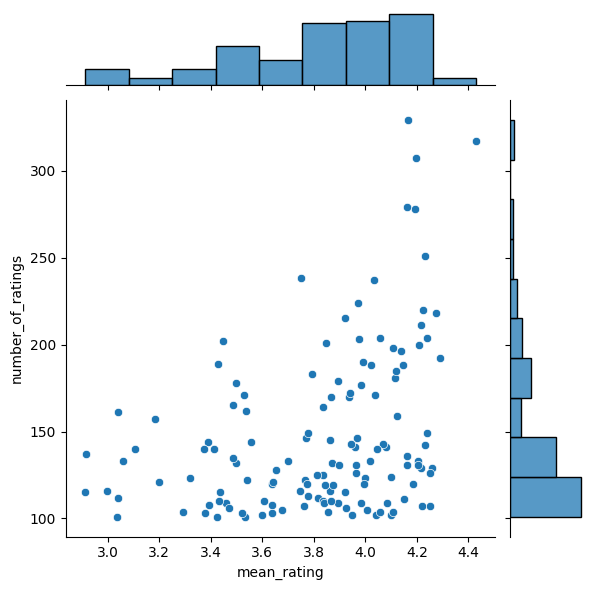

In [74]:
# visualization

sns.jointplot(x='mean_rating', y='number_of_ratings',data=agg_ratings_GT100)

In [75]:
df_G100=pd.merge(df, agg_ratings_GT100, on='title', how='inner')
df_G100.head()

,userId,movieId,rating,timestamp,title,genres,mean_rating,number_of_ratings
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.92093,215


In [76]:
df_G100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19788 entries, 0 to 19787
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   userId             19788 non-null  int64  
 1   movieId            19788 non-null  int64  
 2   rating             19788 non-null  float64
 3   timestamp          19788 non-null  int64  
 4   title              19788 non-null  object 
 5   genres             19788 non-null  object 
 6   mean_rating        19788 non-null  float64
 7   number_of_ratings  19788 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.2+ MB


#### 3. index = movie title, columns= userId ,  values = rating dataframe 

In [77]:
matrix = df_G100.pivot_table(
    index='title',
    columns='userId',
    values='rating'

)

matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,5.0,NaN,3.0,NaN,4.5
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,3.5,NaN,3.0
Aladdin (1992),NaN,NaN,NaN,4.0,4.0,5.0,3.0,NaN,NaN,4.0,...,NaN,NaN,NaN,3.0,3.5,NaN,NaN,3.0,NaN,NaN
Alien (1979),4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,4.0,3.0,4.0,NaN,4.5
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,3.5,NaN,4.5,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Usual Suspects, The (1995)",5.0,NaN,NaN,NaN,4.0,1.0,4.5,5.0,NaN,NaN,...,5.0,5.0,NaN,NaN,NaN,4.5,NaN,4.5,NaN,4.0
WALL·E (2008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.5
Waterworld (1995),NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,...,NaN,3.0,NaN,3.0,NaN,NaN,3.0,3.0,3.0,NaN


In [78]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 2001: A Space Odyssey (1968) to X-Men (2000)
Columns: 597 entries, 1 to 610
dtypes: float64(597)
memory usage: 626.0+ KB


#### 코싸인 유사도 분석
    - index에 내가 분석하고 싶은 값을 넣는다

#### 4. 유사도 분석
- 영화 item에 따른 평점 유사도 분석

In [79]:
# cosine_similarity 분석
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)

cosim = cosine_similarity(matrix_norm.fillna(0))
cos_item_similiarity=pd.DataFrame(data=cosim, index=matrix.index,columns=matrix.index)

In [80]:
# 피어슨 상관분석 통한 유사도 분석

#DataFrame.corr(method='pearson', min_periods=1, numeric_only=False)
item_similiarity=matrix_norm.T.corr()

In [81]:
item_similiarity['2001: A Space Odyssey (1968)']

title
2001: A Space Odyssey (1968)                  1.000000
Ace Ventura: Pet Detective (1994)            -0.036319
Aladdin (1992)                                0.017446
Alien (1979)                                  0.318523
Aliens (1986)                                 0.317386
                                                ...   
Usual Suspects, The (1995)                    0.245279
WALL·E (2008)                                 0.100172
Waterworld (1995)                            -0.447306
Willy Wonka & the Chocolate Factory (1971)    0.087803
X-Men (2000)                                 -0.123862
Name: 2001: A Space Odyssey (1968), Length: 134, dtype: float64

In [82]:
matrix_norm

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,0.105505,NaN,NaN,NaN,...,NaN,NaN,1.105505,NaN,NaN,1.105505,NaN,-0.894495,NaN,0.605505
Ace Ventura: Pet Detective (1994),NaN,NaN,NaN,NaN,-0.040373,-0.040373,NaN,NaN,NaN,NaN,...,NaN,-1.040373,NaN,-1.040373,NaN,NaN,NaN,0.459627,NaN,-0.040373
Aladdin (1992),NaN,NaN,NaN,0.20765,0.207650,1.207650,-0.792350,NaN,NaN,0.20765,...,NaN,NaN,NaN,-0.792350,-0.29235,NaN,NaN,-0.792350,NaN,NaN
Alien (1979),0.030822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.030822,NaN,NaN,0.030822,-0.969178,0.030822,NaN,0.530822
Aliens (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035714,NaN,NaN,-0.464286,NaN,0.535714,NaN,1.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Usual Suspects, The (1995)",0.762255,NaN,NaN,NaN,-0.237745,-3.237745,0.262255,0.762255,NaN,NaN,...,0.762255,0.762255,NaN,NaN,NaN,0.262255,NaN,0.262255,NaN,-0.237745
WALL·E (2008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.942308,NaN,NaN,NaN,NaN,-0.057692,NaN,NaN,NaN,0.442308
Waterworld (1995),NaN,NaN,NaN,NaN,NaN,0.086957,NaN,0.086957,NaN,NaN,...,NaN,0.086957,NaN,0.086957,NaN,NaN,0.086957,0.086957,0.086957,NaN


#### 5.하나의 영화에 대해서 user의 평점을 예측
1. user1을 기준으로 등급을 매긴 영화 목록을 만든다
2. user1이 본영화 평점과 American Pie (1999) 유사도등을 구해서 랭킹을 매긴다
3. 탑 10을 선택한다.
4. 유사도 점수의 가중 평균과 user1등을 사용하여 예측등급을 계산한다.



In [83]:
#### user 1을 이용
picked_user=1

# American Pie (1999)를 이용
picked_movie='American Pie (1999)'

# user1이 본 영화
picked_userid_watch = pd.DataFrame(matrix_norm[picked_user].dropna(axis=0, how='all')).sort_values(ascending=False, by=1).reset_index()
picked_userid_watch= picked_userid_watch.rename(columns={1:'rating'})

In [84]:
picked_userid_watch.head()

,title,rating
0,Dumb & Dumber (Dumb and Dumber) (1994),1.939850
1,Indiana Jones and the Temple of Doom (1984),1.361111
2,X-Men (2000),1.300752
3,E.T. the Extra-Terrestrial (1982),1.233607
4,Ghostbusters (a.k.a. Ghost Busters) (1984),1.225000


In [85]:
# American Pie (1999)와 유사한 영화
picked_movie_sim_score= pd.DataFrame(item_similiarity[picked_movie]).reset_index().rename(columns={'American Pie (1999)':'sim_score'})
picked_movie_sim_score


,title,sim_score
0,2001: A Space Odyssey (1968),0.011490
1,Ace Ventura: Pet Detective (1994),0.173855
2,Aladdin (1992),0.367076
3,Alien (1979),-0.006804
4,Aliens (1986),0.076674
...,...,...
129,"Usual Suspects, The (1995)",0.280924
130,WALL·E (2008),0.060699
131,Waterworld (1995),0.180433
132,Willy Wonka & the Chocolate Factory (1971),0.051963


In [86]:
#### picked_userid_watch와 picked_movie_sim_score merge

picked_userid_watched_sim=pd.merge(picked_userid_watch, picked_movie_sim_score, on='title', how='inner')
picked_userid_watched_sim= picked_userid_watched_sim.sort_values(by='sim_score',ascending=False)[:10]
picked_userid_watched_sim

,title,rating,sim_score
52,Mission: Impossible (1996),-0.537037,0.510888
47,Twister (1996),-0.321138,0.476518
16,Star Wars: Episode I - The Phantom Menace (1999),0.892857,0.443614
10,"Fugitive, The (1993)",1.007895,0.442128
19,"Green Mile, The (1999)",0.851351,0.429560
42,Braveheart (1995),-0.031646,0.424226
38,Toy Story (1995),0.079070,0.420117
6,"Terminator, The (1984)",1.103053,0.372331
50,Independence Day (a.k.a. ID4) (1996),-0.445545,0.368944
26,American History X (1998),0.782946,0.365361


In [87]:
predict_rating = round(np.average(picked_userid_watched_sim['rating'],weights=picked_userid_watched_sim['sim_score']),6)

In [88]:
predict_rating

0.313184

#### 6.Movie Recommandation
1. 대상 유저가 못본 영화 목록 만든다
2. 안본 영화에 대한 predict_rating값을 구한다
3. 높은 predict_rating 순으로 상위 10개 영화를 추천

In [89]:
## 보지못한 영화
picked_df =pd.DataFrame(matrix_norm[1].isna()).reset_index()
picked_userid_unwatched=picked_df[picked_df[1]==True]['title'].values.tolist()
picked_userid_unwatched


['2001: A Space Odyssey (1968)',
 'Ace Ventura: Pet Detective (1994)',
 'Aladdin (1992)',
 'Aliens (1986)',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'American Pie (1999)',
 'Apollo 13 (1995)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 'Babe (1995)',
 'Batman Begins (2005)',
 'Batman Forever (1995)',
 'Beautiful Mind, A (2001)',
 'Beauty and the Beast (1991)',
 'Blade Runner (1982)',
 'Bourne Identity, The (2002)',
 'Breakfast Club, The (1985)',
 'Catch Me If You Can (2002)',
 'Cliffhanger (1993)',
 'Clueless (1995)',
 'Crimson Tide (1995)',
 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)',
 'Dark Knight, The (2008)',
 'Departed, The (2006)',
 'Die Hard (1988)',
 'Die Hard: With a Vengeance (1995)',
 'Donnie Darko (2001)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 "Ferris Bueller's Day Off (1986)",
 'Fifth Element, The (1997)',
 'Finding Nemo (2003)',
 'Firm, The (1993)',
 'Four Weddings and a Funeral (1994)',
 'Ghost (1990)',
 'Godfather, The 

In [90]:
#### 안본영화에 대한 predict_rating으로 merge

rating_prediction={}

for picked_movie in picked_userid_unwatched:
    picked_movie_sim_score = item_similiarity[picked_movie].reset_index().rename(columns={picked_movie:'sim_score'})
    
    picked_userid_watched_sim=pd.merge(picked_userid_watch, picked_movie_sim_score, on='title', how='inner')
    picked_userid_watched_sim= picked_userid_watched_sim.sort_values(by='sim_score',ascending=False)[:10]

    predict_rating = round(np.average(picked_userid_watched_sim['rating'],weights=picked_userid_watched_sim['sim_score']),6)

    rating_prediction[picked_movie] = predict_rating

In [91]:
rating_prediction

{'2001: A Space Odyssey (1968)': 0.590347,
 'Ace Ventura: Pet Detective (1994)': 0.296757,
 'Aladdin (1992)': 0.658992,
 'Aliens (1986)': 0.327327,
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)": 0.453496,
 'American Pie (1999)': 0.313184,
 'Apollo 13 (1995)': 0.640587,
 'Austin Powers: The Spy Who Shagged Me (1999)': 0.991166,
 'Babe (1995)': 0.489272,
 'Batman Begins (2005)': 0.650354,
 'Batman Forever (1995)': 0.216289,
 'Beautiful Mind, A (2001)': 0.665253,
 'Beauty and the Beast (1991)': 0.439208,
 'Blade Runner (1982)': 0.46937,
 'Bourne Identity, The (2002)': 0.592828,
 'Breakfast Club, The (1985)': 0.379866,
 'Catch Me If You Can (2002)': 0.613671,
 'Cliffhanger (1993)': 0.147104,
 'Clueless (1995)': 0.287108,
 'Crimson Tide (1995)': -0.005331,
 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)': 0.744494,
 'Dark Knight, The (2008)': 0.491468,
 'Departed, The (2006)': 0.565131,
 'Die Hard (1988)': 0.260045,
 'Die Hard: With a Vengeance (1995)': 0.476277,
 'Donni

In [92]:
import operator

sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:10]

[('Austin Powers: The Spy Who Shagged Me (1999)', 0.991166),
 ('Lord of the Rings: The Return of the King, The (2003)', 0.873138),
 ("There's Something About Mary (1998)", 0.795021),
 ('Fifth Element, The (1997)', 0.756015),
 ('Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 0.744494),
 ('Home Alone (1990)', 0.740627),
 ('Godfather, The (1972)', 0.68168),
 ('Terminator 2: Judgment Day (1991)', 0.668194),
 ('Truman Show, The (1998)', 0.668172),
 ('Beautiful Mind, A (2001)', 0.665253)]

In [102]:
def item_based_recommand(picked_user=1, number_of_similar_items=5 , number_of_recommandations=3):
    import operator
    picked_df = pd.DataFrame(matrix_norm[picked_user].isna()).reset_index()
    picked_userid_unwatched = picked_df[picked_df[picked_user]==True]['title'].values.tolist()
    
    #user 1이 본 영화
    picked_userid_watched = pd.DataFrame(matrix_norm[picked_user].dropna(axis=0, how='all')).sort_values(by=picked_user, ascending=False).reset_index()
    picked_userid_watched = picked_userid_watched.rename(columns={picked_user: 'rating'})
    
    # 안본영화에 대한  predict_rating 으로 merge

    rating_prediction = {}

    for picked_movie in picked_userid_unwatched:
        picked_movie_sim_score = item_similiarity[picked_movie].reset_index().rename(columns={picked_movie:'sim_score'})
        picked_userid_watched_sim = pd.merge(picked_userid_watched, picked_movie_sim_score , on='title', how='inner')
        picked_userid_watched_sim = picked_userid_watched_sim.sort_values(by='sim_score', ascending=False)[:number_of_similar_items]
        predict_rating = round(np.average(picked_userid_watched_sim['rating'] ,weights=picked_userid_watched_sim["sim_score"] ) , 6)

        rating_prediction[picked_movie] = predict_rating
        
    return  sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommandations]
    

In [105]:
추천유저 = int(input('원하는 유저를 적어주세요'))
number_of_similar_items = int(input('유사 아이템 수를 적어주세요'))
number_of_recommandations = int(input('추천 영화 개수를 적어주세요'))
recmoandation_dict = item_based_recommand(picked_user=추천유저, number_of_similar_items=number_of_similar_items , number_of_recommandations=number_of_recommandations)

pprint.pp(recmoandation_dict)

[('X-Men (2000)', 0.342362),
 ('WALL·E (2008)', 0.252931),
 ('Mask, The (1994)', 0.246204),
 ('Star Wars: Episode I - The Phantom Menace (1999)', 0.240559),
 ('Taxi Driver (1976)', 0.219789)]
